<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# 0. Идентификация

**Logistic Regression CV**: 0.8444573160357643


**Logistic Regression Grid Search CV** best score: 0.8445682657572224


**Cat Boost** 

Train 0.8891998042947855 

Test0.8428408981046255

**Cat Boost GC**
Train 0.9134646367456669

**Kaggle** 
0.84496

**Kaggle Team Name**
`Алексей Волков`

# 1. Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## 1.2 Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [98]:
data = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
data_y_test = pd.read_csv('./submission.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

### 1.2.1 Обзор данных: начало, конец и случайные строки из набора

In [5]:
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [6]:
data.tail(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0
5281,19,75.90,1375.6,Female,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,0


In [7]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2684,71,61.4,4310.35,Female,0,Yes,No,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0
2488,28,59.0,1654.45,Female,0,No,No,Yes,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0
305,54,20.1,1079.45,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4781,71,19.9,1397.3,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
1538,67,54.2,3838.2,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,No,No,No,No,Two year,Yes,Bank transfer (automatic),0


### 1.2.2 Поиск пропусков в данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Для верности, посмотрим вручную на столбцы и пропуски в них

In [9]:
data.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Судя по типам столбцов:

    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod', 

жизнь сложна и полна удивительного. Остается открытым вопрос, какие значения могут быть у каждого из этих признаков? Например, что может быть в поле `'HasChild'`?

Прогнозирование оттока пользователей -- задача известная. По ней существует несколько наборов [данных](https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266). Поэтому надо идти в оригинальные статьи и глубже погружаться в описание собранных данных.

Переберем все признаки, в надежде посмотреть на их потенциальные значения


In [10]:
for idx, col in enumerate(cat_cols):
    print(f"{idx}. [{col}]:")
    print(data[col].value_counts(), end='\n')
    
    print('\n\n')

0. [Sex]:
Male      2655
Female    2627
Name: Sex, dtype: int64



1. [IsSeniorCitizen]:
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64



2. [HasPartner]:
No     2705
Yes    2577
Name: HasPartner, dtype: int64



3. [HasChild]:
No     3676
Yes    1606
Name: HasChild, dtype: int64



4. [HasPhoneService]:
Yes    4761
No      521
Name: HasPhoneService, dtype: int64



5. [HasMultiplePhoneNumbers]:
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64



6. [HasInternetService]:
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64



7. [HasOnlineSecurityService]:
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64



8. [HasOnlineBackup]:
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64



9. [HasDeviceProtection]:
No      

Нам намекают, что типы данных, определенные при считывании для некоторых признаков, не совпадают с их реальным типом данных. 
Удается заметить, что `'TotalSpent'` -- признак численный по смыслу, а в датафрейме в нем лежат `objects`. 

Следовательно, необходимо насильное преобразование

In [11]:
# насильное преобразование выбрасывает исключение при парсинге пробелов -- пустых значений признака
# data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])
data[pd.to_numeric(data.TotalSpent, errors='coerce').isnull()].value_counts()

ClientPeriod  MonthlySpending  TotalSpent  Sex     IsSeniorCitizen  HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  HasInternetService  HasOnlineSecurityService  HasOnlineBackup      HasDeviceProtection  HasTechSupportAccess  HasOnlineTV          HasMovieSubscription  HasContractPhone  IsBillingPaperless  PaymentMethod              Churn
0             19.70                        Male    0                Yes         Yes       Yes              No                       No                  No internet service       No internet service  No internet service  No internet service   No internet service  No internet service   One year          Yes                 Mailed check               0        1
              20.00                        Female  0                Yes         Yes       Yes              No                       No                  No internet service       No internet service  No internet service  No internet service   No internet service  No internet service 

Попробуем найти в численных признаках нулевые значения и пропуски в категориальных переменных (видимо, это пустные записи?)

In [12]:
for idx, col in enumerate(num_cols):
    print(f"{idx}. [{col}]:")
    if (data[data[col] == 0].shape[0] > 0):
        print(data[data[col] == 0].shape, end='\n')
    else:
        print('OK')

0. [ClientPeriod]:
(9, 20)
1. [MonthlySpending]:
OK
2. [TotalSpent]:
OK


In [13]:
for idx, col in enumerate(cat_cols):
    print(f"{idx}. [{col}]:")
    if (data[data[col] == ' '].shape[0] > 0):
        print(data[data[col] == ' '].shape, end='\n')
    else:
        print('OK')

0. [Sex]:
OK
1. [IsSeniorCitizen]:
OK
2. [HasPartner]:
OK
3. [HasChild]:
OK
4. [HasPhoneService]:
OK
5. [HasMultiplePhoneNumbers]:
OK
6. [HasInternetService]:
OK
7. [HasOnlineSecurityService]:
OK
8. [HasOnlineBackup]:
OK
9. [HasDeviceProtection]:
OK
10. [HasTechSupportAccess]:
OK
11. [HasOnlineTV]:
OK
12. [HasMovieSubscription]:
OK
13. [HasContractPhone]:
OK
14. [IsBillingPaperless]:
OK
15. [PaymentMethod]:
OK


Мы увидели, что есть проблемы с `'TotalSpent'` и с `'ClientPeriod'` -- в этих столбцах что-то неладное. Попробуем посмотреть сводную таблицу, учитывая первый признак пустым, а второй -- нулевым

In [14]:
data[(data['TotalSpent'].str.isspace() == True) & (data['ClientPeriod'] == 0)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


### 1.2.3 Преобразование типов признаков

Можно было бы трактовать эти записи, опираясь на смысл полей набора данных. Мы же учтем это при построении трансформера для признаков, заменяя пробелы в `'TotalSpent'` на `0`, а в `'ClientPeriod'` менять, наверное, ничего не будем.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnTypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['TotalSpent'][X['TotalSpent'].str.isspace() == True] = '0'
        X['TotalSpent'] = X['TotalSpent'].astype(float)

        return X

In [16]:
col_type_transformer = ColumnTypeTransformer()
data_train = col_type_transformer.transform(data)
data_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

C:\Users\user\AppData\Local\Temp/ipykernel_14828/657926258.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['TotalSpent'][X['TotalSpent'].str.isspace() == True] = '0'


In [99]:
data_test = pd.concat([data_test, data_y_test['Churn']], axis=1)
data_test = col_type_transformer.transform(data_test)
data_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

C:\Users\user\AppData\Local\Temp/ipykernel_14828/657926258.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['TotalSpent'][X['TotalSpent'].str.isspace() == True] = '0'


### 1.2.4 Удаление дубликатов в обучающей выборке

In [18]:
data_train.duplicated().sum()

14

In [19]:
data_train = data_train.drop_duplicates().reset_index(drop=True)

# 2. Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

## 2.1 Визуализация признаков

1) Для численных призанков постройте гистограмму (plt.hist(...)) или boxplot (plt.boxplot(...)). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать data.value_counts() и построить bar диаграммы plt.bar(...) или круговые диаграммы plt.pie(...) (хорошо, елси вы сможете это сделать на одном гарфике с помощью plt.subplots(...)).

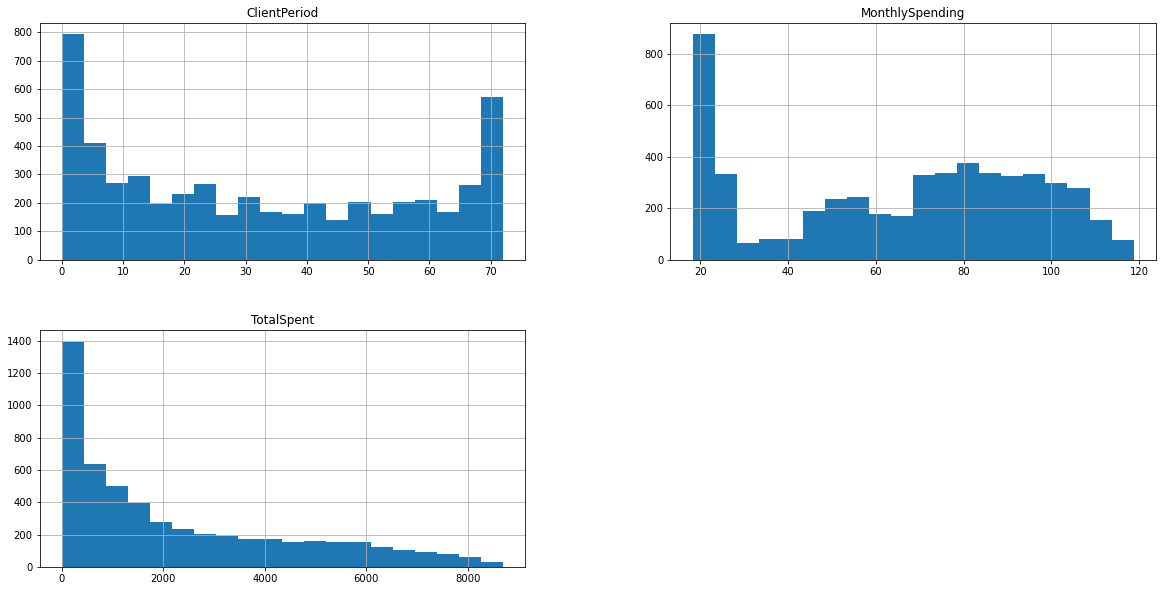

In [20]:
data[num_cols].hist(figsize=(20, 10), bins=20);

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [21]:
%matplotlib inline

In [22]:
import seaborn as sns

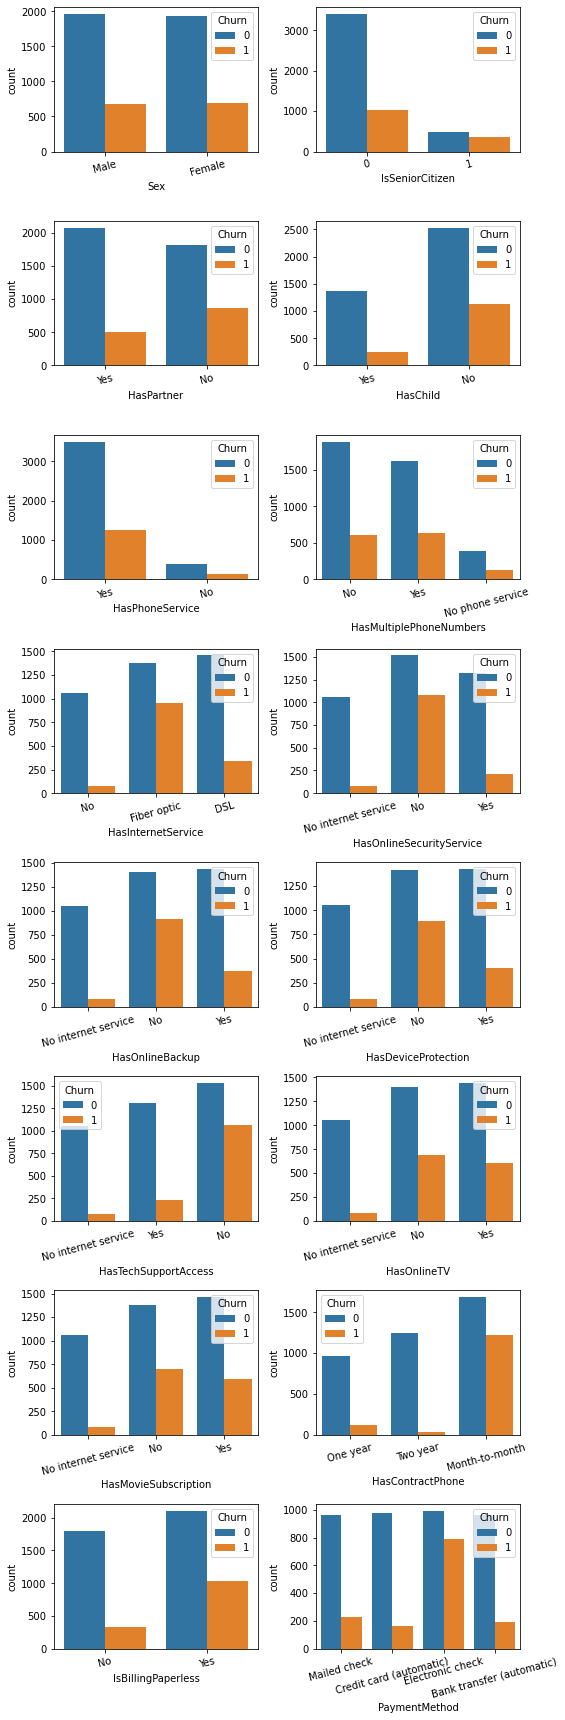

In [23]:
num_cat_cols = len(cat_cols)
num_plot_rows = num_cat_cols // 2
num_plot_cols = num_cat_cols // 8
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(8, 24))

for i in range(num_plot_rows):
    for j in range(num_plot_cols):
        axs[i][j].tick_params(axis='x', labelrotation=15)
        sns.countplot(x=cat_cols[i*num_plot_cols + j], 
                      hue=target_col, 
                      data=data_train, 
                      ax=axs[i][j], 
                      orient='v')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()

In [24]:
for idx, col in enumerate(cat_cols):
    print(f"{idx}. [{col}]:")
    print(data_train[col].value_counts(), end='\n')
    
    print('\n\n')

0. [Sex]:
Male      2647
Female    2621
Name: Sex, dtype: int64



1. [IsSeniorCitizen]:
0    4427
1     841
Name: IsSeniorCitizen, dtype: int64



2. [HasPartner]:
No     2691
Yes    2577
Name: HasPartner, dtype: int64



3. [HasChild]:
No     3662
Yes    1606
Name: HasChild, dtype: int64



4. [HasPhoneService]:
Yes    4747
No      521
Name: HasPhoneService, dtype: int64



5. [HasMultiplePhoneNumbers]:
No                  2497
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64



6. [HasInternetService]:
Fiber optic    2335
DSL            1798
No             1135
Name: HasInternetService, dtype: int64



7. [HasOnlineSecurityService]:
No                     2604
Yes                    1529
No internet service    1135
Name: HasOnlineSecurityService, dtype: int64



8. [HasOnlineBackup]:
No                     2324
Yes                    1809
No internet service    1135
Name: HasOnlineBackup, dtype: int64



9. [HasDeviceProtection]:
No      

## 2.2 Распределение целевой переменной
2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

In [25]:
data_train[target_col].value_counts()

0    3894
1    1374
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

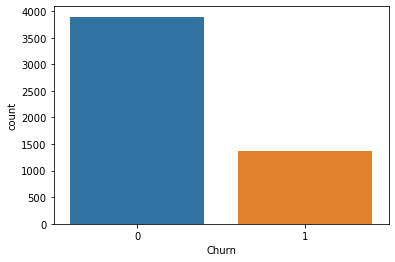

In [26]:
sns.countplot(data=data_train, x=target_col)

In [27]:
from sklearn.utils import class_weight

y = data_train[target_col]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

pd.DataFrame.from_dict(class_weights_dict, 
                       orient='index',
                       columns=['Class weight'])

,Class weight
0,0.676425
1,1.917031


Набора данных не сбалансирован по количеству примеров в классах целевой переменной.

## 2.3 Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [28]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

In [29]:
X_train = data_train[feature_cols]  
y_train = data_train[target_col]  

print(X_train.shape, y_train.shape)

(5268, 19) (5268,)


In [30]:
X_test = data_test[feature_cols]  
y_test = data_test[target_col]
print(X_test.shape, y_test.shape)

(1761, 19) (1761,)


In [31]:
preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

In [32]:
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression(random_state=42, 
                                   solver='saga', 
                                   max_iter=10000))
    ])

In [33]:
from sklearn.model_selection import cross_val_score

In [34]:
roc_aucs = cross_val_score(pipeline, 
                           X_train,
                           y_train, 
                           cv=5, 
                           n_jobs=-1,
                           scoring='roc_auc')

In [35]:
print(f'scores: {roc_aucs}')
print(f'mean: {roc_aucs.mean()}')
print(f'std: {roc_aucs.std()}')

scores: [0.862341   0.83435173 0.83555141 0.85531938 0.83472307]
mean: 0.8444573160357643
std: 0.011949929579898304


На **Kaggle** LR CV
```
mean: 0.8444573160357643
std: 0.011949929579898304
```

In [36]:
params = [
    {
        'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__class_weight': ['balanced', None],
        'clf__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
]

In [37]:
gcv = GridSearchCV(estimator=pipeline, 
                   param_grid=params, 
                   cv=5, 
                   scoring='roc_auc', 
                   n_jobs=-1,
                   verbose=1,
                   refit=True)

In [38]:
grid_result = gcv.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


### 2.3.1 Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [40]:
print('best params:', grid_result.best_params_)
print('best score:', grid_result.best_score_)

best params: {'clf__C': 10, 'clf__class_weight': None, 'clf__l1_ratio': 0.4, 'clf__penalty': 'elasticnet'}
best score: 0.8445682657572224


На **Kaggle**  GC LR
`best score: 0.8445682657572224`

## 2.4 Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [52]:
!pip install catboost

Could not fetch URL https://pypi.org/simple/catboost/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/catboost/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1125)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1125)'))) - skipping


ERROR: Could not find a version that satisfies the requirement catboost
ERROR: No matching distribution found for catboost


In [57]:
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv

### 2.4.1. Стандартные параметры

In [58]:
X_train_origins, X_test_origins, y_train_origins, y_test_origins = train_test_split(X_train.values, 
                                                                                    y_train.values, 
                                                                                    train_size=0.8, 
                                                                                    random_state=42)

In [61]:
catboost_train_splitted = Pool(data=X_train_origins,
                               label=y_train_origins,
                               cat_features=cat_cols,
                               feature_names=list(X_train.columns),
                              )

In [64]:
boosting_model = CatBoostClassifier(n_estimators=200, 
                                    loss_function='Logloss', 
                                    random_state=42,
                                    verbose=False,
                                    eval_metric='AUC',
                                    custom_metric='AUC:hints=skip_train~false')

In [65]:
boosting_model.fit(catboost_train_splitted)

In [67]:
y_train_predicted = boosting_model.predict_proba(X_train_origins)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origins)[:, 1]

In [70]:
train_auc = roc_auc_score(y_train_origins, y_train_predicted)
test_auc = roc_auc_score(y_test_origins, y_test_predicted)

print(train_auc, test_auc)

0.8891998042947855 0.8428408981046255


### 2.4.2 Подбор параметров
2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

In [89]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1],
    'iterations': [100, 200, 500, 1000],
    'min_data_in_leaf': [20, 50, 100],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [0.01, 0.05, 0.1, 0.5, 1],
}

In [92]:
clf = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',
                         cat_features=cat_cols, 
                         random_state=42,
                         loss_function='Logloss',
                         silent=True)

In [93]:
clf.grid_search(param_grid, X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 0.8241311705
bestIteration = 99

0:	loss: 0.8241312	best: 0.8241312 (0)	total: 2.64s	remaining: 52m 50s

bestTest = 0.8495110281
bestIteration = 99

1:	loss: 0.8495110	best: 0.8495110 (1)	total: 4.85s	remaining: 48m 27s

bestTest = 0.860851908
bestIteration = 98

2:	loss: 0.8608519	best: 0.8608519 (2)	total: 7.31s	remaining: 48m 36s

bestTest = 0.8619978994
bestIteration = 71

3:	loss: 0.8619979	best: 0.8619979 (3)	total: 9.8s	remaining: 48m 51s

bestTest = 0.859990664
bestIteration = 32

4:	loss: 0.8599907	best: 0.8619979 (3)	total: 12.2s	remaining: 48m 42s

bestTest = 0.82608239
bestIteration = 12

5:	loss: 0.8260824	best: 0.8619979 (3)	total: 14.6s	remaining: 48m 16s

bestTest = 0.8501855526
bestIteration = 99

6:	loss: 0.8501856	best: 0.8619979 (3)	total: 16.9s	remaining: 48m 3s

bestTest = 0.8608005602
bestIteration = 99

7:	loss: 0.8608006	best: 0.8619979 (3)	total: 19.4s	remaining: 48m 4s

bestTest = 0.8611226514
bestIteration = 58

8:	loss: 0.8611227	best: 0.8619979

{'params': {'min_data_in_leaf': 20,
  'depth': 10,
  'iterations': 200,
  'learning_rate': 0.02,
  'l2_leaf_reg': 0.01},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
      

In [94]:
clf.get_params()

{'loss_function': 'Logloss',
 'silent': True,
 'eval_metric': 'AUC:hints=skip_train~false',
 'random_state': 42,
 'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'min_data_in_leaf': 20,
 'depth': 10,
 'iterations': 200,
 'learning_rate': 0.02,
 'l2_leaf_reg': 0.01}

In [95]:
roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])

0.9134646367456669

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# 3. Предсказания

In [96]:
best_model = clf

In [102]:
best_model.predict_proba(X_test)[:, 1]

array([0.01171566, 0.6669191 , 0.6414944 , ..., 0.89777622, 0.54820438,
       0.00685018])

In [103]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./submission.csv', index=False, columns=['Id', 'Churn'])

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.